In [28]:
##Import
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

import soundfile as sf
import IPython.display
import librosa

from scipy.signal import iirfilter, welch


##Variables
notes = {16.351 : 'Do', 17.323 : 'Do#', 18.354 : 'Ré', 19.445 : 'Re#', 20.601 : 'Mi', 21.827 : 'Fa',
          23.124 : 'Fa#', 24.499 : 'Sol', 25.956 : 'Sol#', 27.5 : 'La', 29.135 : 'La#', 30.868 : 'Si'} 

##Fonctions
def spectrogramme(x_instrument,Fe):
    f, t, tfct = sig.stft(x_instrument, fs=1, nperseg=4096)
    nperseg=4096
    image = np.log(np.abs(tfct))
    #print(np.max(image),np.min(image))
    #print(image)
    cmap = plt.get_cmap('PiYG')
    plt.figure(figsize=(10,4))
    plt.pcolormesh(t/Fe, f*Fe, image, shading='auto', cmap=cmap)  
    plt.xlabel('s')
    plt.ylabel('Hz')
    plt.title('affichage du spectrogramme')
    x_max=len(image[1,:])/Fe/2*nperseg
    x_ticks = np.arange(0, x_max, 0.5)
    plt.xticks(x_ticks)
    #plt.yscale('log')  # Ajoutez cette ligne pour définir l'échelle de l'axe y sur 'log'
    plt.show()

def show_note(x_instrument,Fe,t_deb,t_fin):
    f, t, tfct = sig.stft(x_instrument, fs=1, nperseg=4096)
    image = np.log(np.abs(tfct))
    #print(np.max(image),np.min(image))
    #print(image)
    cmap = plt.get_cmap('PiYG')
    plt.figure(figsize=(10,4))
    plt.pcolormesh(t/Fe, f*Fe, image, shading='auto', cmap=cmap)  
    plt.xlabel('s')
    plt.ylabel('Hz')
    plt.title('affichage du spectrogramme')
    x_max=len(image[1,:])/Fe/2*4096
    x_ticks = np.arange(0, x_max, 0.5)
    plt.xticks(x_ticks)
    plt.xlim(t_deb,t_fin)
    #plt.yscale('log')  # Ajoutez cette ligne pour définir l'échelle de l'axe y sur 'log'
    plt.show()

def show_signal_F(x,Fe):
    T=[i*1/Fe for i in range(len(x))]
    Tec=T[-1]
    F=[i/Tec for i in range(len(x))]
    plt.figure(figsize=(10,4))
    plt.plot(F,x,color='b')
    plt.xlabel('Fréquence en Hz')
    plt.ylabel('Amplitude')
    plt.title('TF du Signal audio')
    plt.grid()
    plt.show()


def detect_color_change(spectrogram, y_value_hz, threshold, Fe, nperseg):
    # Convert the given y value in Hz to the corresponding row index
    row_index = int(y_value_hz * nperseg / Fe)

    # Get the row of the spectrogram corresponding to the given y value
    row = spectrogram[row_index, :]

    # Calculate the difference between consecutive values
    diff = np.diff(row)

    # Find where the difference exceeds the threshold and is positive
    change_points = np.where(diff > threshold)[0]
    t_max = len(row)/Fe/2*nperseg
    # Convert the indices to time values
    change_times = change_points /Fe * nperseg/2
    change_times = np.insert(change_times, 0, 0)
    change_times = np.append(change_times, t_max)
    return change_times


def instant_note(liste,epsilon):
    L=[]
    for i in range(len(liste)-1):
        if liste[i]-epsilon>0:
            L+=[(liste[i]-epsilon,liste[i+1]-epsilon)]
        else:
            L+=[(0,liste[i+1]-epsilon)]
    return L

def get_note(son,Fe, notes = notes):
    found = []
    for note in notes.keys():
        #while note_mult < (Fe/2):
        for k in range(2,11):
            note_mult = note * 2**k
            #print(f'Nous travaillons sur la note {notes[note]}...\n La frequence est {note_mult}')
            f_resonance = note_mult # Fréquence de résonance en Hz
            bandwidth = 1.5  # Bande passante en Hz
            fs = Fe  # Fréquence d'échantillonnage en Hz

            # Conception du filtre
            f_lower = f_resonance - bandwidth / 2  # Fréquence de coupure inférieure
            f_upper = f_resonance + bandwidth / 2  # Fréquence de coupure supérieure
            f_lower_normalized = f_lower*2 / fs  # Fréquence de coupure inférieure normalisée
            f_upper_normalized = f_upper*2 / fs  # Fréquence de coupure supérieure normalisée
            try:
                b, a = iirfilter(2, [f_lower_normalized, f_upper_normalized], btype='band', ftype='butter')
            except:
                #print(f'Erreur pour la note {notes[note]}... \n à la fréquence {note_mult} Hz: f_lower_normalized = {f_lower_normalized} et f_upper_normalized = {f_upper_normalized}')
                continue
            #reponse_en_frequence(b, a)
            #son = son*np.hanning(len(son))  # Application d'une fenêtre de Hanning
            son_filtre = sig.lfilter(b, a, son)

            #IPython.display.Audio(son_filtre, rate=Fe)

            # Application du filtre et tracé du spectre
            freq, Pxx = welch(son, fs=fs)
            #plt.semilogy(freq, Pxx, label='Signal d\'origine')
            #print(Pxx)
            seuil = 0.4*np.mean(Pxx)

            freq, Pxx_filtre = welch(son_filtre, fs=fs)
            #plt.semilogy(freq, Pxx_filtre, label='Signal filtré')


            # Trouver l'indice correspondant à f_resonance 
            idx = np.abs(freq - f_resonance).argmin()

            # Vérifier si la valeur de Pxx_filtre à cet indice est supérieure au seuil
            #print(f"La valeur de Pxx_filtre à {f_resonance} est {Pxx_filtre[idx]}")
            if Pxx_filtre[idx] > seuil:
                #print(f"La valeur de Pxx_filtre à {f_resonance} est supérieure au seuil.")
                found.append(notes[note])
                break
    return found

def find_instr(wav_file: str,t_start,t_end,total_time):

    data, sample_rate = librosa.load(wav_file)

    # t = range(len(data))
    # plt.plot(t, data)
    # plt.show()
    ind_start = int(t_start*len(data)/total_time)
    ind_end = int(t_end*len(data)/total_time)
    data=data[ind_start:ind_end]
    spectral_centroid = librosa.feature.spectral_centroid(
        y=data, sr=sample_rate)[0]

    mean = sum(spectral_centroid) / len(spectral_centroid)

    # t = range(len(spectral_centroid))
    # plt.plot(t, spectral_centroid)
    # plt.show()

    # print("SR = ", mean)

    if mean < 2000:
        return "guitar"
    elif mean > 3500:
        return "drums"
    else:
        return "both"

def main(son,freq):
    x_son, Fe = sf.read(f"wav/{son}.wav")
    x_son=x_son[:,0]
    f, t, tfct = sig.stft(x_son, fs=1, nperseg=4096)
    image = np.log(np.abs(tfct))
    instants = detect_color_change(image, freq, 2,Fe, 4096)
    plage = instant_note(instants,0.05)     #on prend chaque instant moins 0.1
    L=[[x,'instrument',''] for x in instants[:-1]]
    for i,couple in enumerate(plage):
        notes = get_note(x_son[int(np.floor(couple[0]*Fe)):int(np.floor(couple[1]*Fe))],Fe)
        instrument= find_instr(f"wav/{son}.wav",couple[0],couple[1],instants[-1])
        L[i][1]=instrument
        L[i][2]=notes
    return L

def tab(liste):
    tableau = np.zeros((14,len(liste)))
    for i in range(len(liste)):
        if liste[i][1] == 'guitar':
            tableau[12,i] = 1
        elif liste[i][1] == 'drums':
            tableau[13,i] = 1
        elif liste[i][1] == 'both':
            tableau[12,i] = 1
            tableau[13,i] = 1
        notes = liste[i][2]
        for note in notes:
            if note == 'Do':
                tableau[0,i] = 1
            elif note == 'Do#':
                tableau[1,i] = 1
            elif note == 'Ré':
                tableau[2,i] = 1
            elif note == 'Re#':
                tableau[3,i] = 1
            elif note == 'Mi':
                tableau[4,i] = 1
            elif note == 'Fa':
                tableau[5,i] = 1
            elif note == 'Fa#':
                tableau[6,i] = 1
            elif note == 'Sol':
                tableau[7,i] = 1
            elif note == 'Sol#':
                tableau[8,i] = 1
            elif note == 'La':
                tableau[9,i] = 1
            elif note == 'La#':
                tableau[10,i] = 1
            elif note == 'Si':
                tableau[11,i] = 1
    return tableau

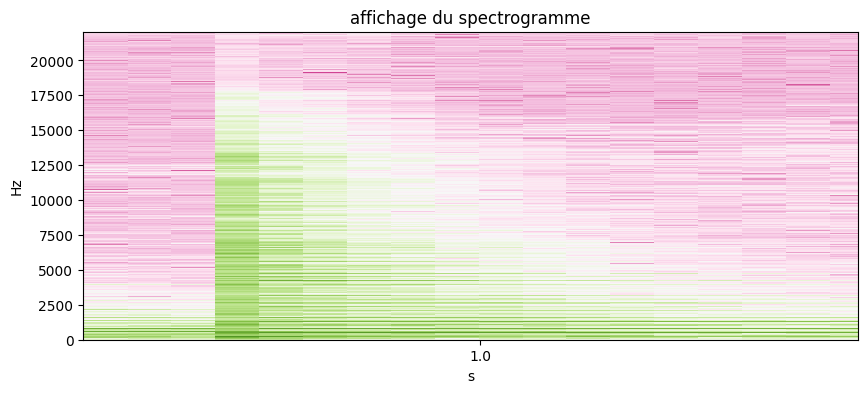

[[0.0, 'guitar', ['Sol']], [0.6965986394557823, 'guitar', ['Do', 'Sol']], [1.4396371882086167, 'guitar', ['Si']], [2.182675736961451, 'guitar', []], [2.2291156462585033, 'guitar', ['Do', 'Si']], [2.9257142857142857, 'guitar', ['Ré']], [3.7151927437641725, 'guitar', ['La']], [4.4117913832199545, 'guitar', []], [4.458231292517007, 'guitar', ['Ré', 'La']], [5.944308390022676, 'guitar', ['Do', 'Do#', 'Fa', 'Fa#', 'Sol', 'Sol#', 'La', 'La#', 'Si']], [6.6873469387755105, 'guitar', ['Fa#', 'Sol', 'Sol#', 'La', 'La#', 'Si']], [7.430385487528345, 'guitar', ['La', 'Si']], [8.17342403628118, 'guitar', ['Do', 'Fa', 'Fa#', 'Sol', 'Sol#', 'La', 'La#', 'Si']], [8.916462585034013, 'guitar', []], [8.962902494331066, 'drums', ['Do', 'Fa#', 'Sol', 'Sol#', 'La', 'La#', 'Si']], [12.863854875283447, 'both', []]]


In [29]:
##Guitare et Drums

x_guitare_drums, Fe = sf.read("audio/guitare&drums.wav")
x_guitare_drums = x_guitare_drums[:,0] 


show_note(x_guitare_drums,Fe,0.58,1.4)
print(main('guitare&drums',5000))
plt.imshow(1-tab(main('guitare&drums',5000)), cmap='hot', interpolation='nearest')
plt.show()
spectrogramme(x_guitare_drums,Fe)
IPython.display.Audio(x_guitare_drums, rate=Fe)

[[0.0, 'guitar', ['Do', 'Sol']], [0.46439909297052157, 'guitar', ['Do#', 'Sol', 'Sol#']], [0.9752380952380952, 'guitar', ['Ré', 'Re#', 'Sol#', 'La']], [1.9504761904761905, 'guitar', []], [2.089795918367347, 'both', []], [2.2291156462585033, 'guitar', ['Mi', 'Fa', 'Fa#', 'Si']], [3.4829931972789114, 'guitar', ['Fa#', 'Sol']], [3.947392290249433, 'guitar', ['Sol', 'Sol#', 'La']], [4.96907029478458, 'guitar', ['La', 'La#']], [5.433469387755102, 'guitar', []], [5.479909297052155, 'guitar', ['Do', 'Sol', 'Si']], [10.95981859410431, 'guitar', []]]


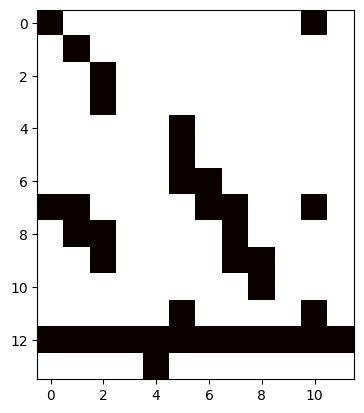

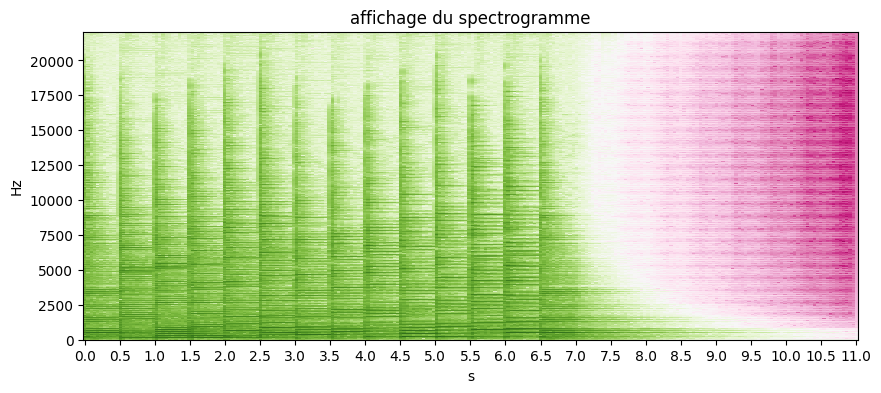

In [ ]:
x_guitare, Fe = sf.read("audio/gamme_demiTon_guitare.wav")
x_guitare = x_guitare[:,0] 

print(main('gamme_demiTon_guitare',5000))
plt.imshow(1-tab(main('gamme_demiTon_guitare',5000)), cmap='hot', interpolation='nearest')
plt.show()
spectrogramme(x_guitare,Fe)
IPython.display.Audio(x_guitare, rate=Fe)